## Extreme precipitation in the Third Pole region : GPM, MSWEP and CNRR 

In [2]:
import numpy as np
import os
import glob 
import random 

import matplotlib.pyplot as plt
import cartopy
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as colors

import scipy
from scipy import ndimage
from scipy.stats import skew
from scipy.ndimage import label, generate_binary_structure
import matplotlib.pyplot as plt

from netCDF4 import Dataset
from collections import Counter 

from numpy import genfromtxt

import pandas as pd 

In [2]:
## import my own functions

from mcs_functions import *
filename='.........'

In [58]:
# This function creates a dictionary containing all hourly files within one month, keys are month for year and values are the corresponding files 
def create_dic():
    files={}
    keys=[]
    values=[]
    
    working_dir= '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/'
    
    for month in np.arange(1,13,1):
        if month < 10:
            k = '0'+str(month)
            keys.append(k)
            values.append(glob.glob(working_dir + 'GPM_IMERG_????' + str(k) + '*cumprec*.nc4'))
        else:
            k = str(month)
            keys.append(str(month))  
            values.append(glob.glob(working_dir + 'GPM_IMERG_????' + str(k) + '*cumprec*.nc4'))
                          
    files= dict(zip(keys, values))
                          
    return files 
            

In [59]:
files = create_dic()


In [31]:
# save daily all grid values for each month where rain rate > 1mm/day 
def extract_rain_rates(prec, rr):
    for idx, row in enumerate(prec):
        for x in row:
            if x >= 0.1:
                rr= np.append(rr, x)         
    return rr

In [32]:
# save daily all grid values for each month where rain rate > 1mm/day 
def eca_ptot(prec, total_rr, rr99, pp):
    for idx, row in enumerate(prec):
        for x in row:
            if x > 0:
                total_rr += x
                if x >= pp:
                    rr99 += x
    return total_rr, rr99

## Extract elevations > 3000 m ASL 

In [95]:
# extract only values above 3000 m a.s.l. 
def read_in_netcdf_dem(file):
    dataset = Dataset(file)    
    dem= np.array(dataset["Band1"])
    lon= np.array(dataset["lon"])
    lat= np.array(dataset["lat"])
    dataset.close()
    return dem, lon, lat

In [4]:
import xarray as xr
import xesmf as xe
# open netCDF file with xarray
ds = '/media/juli/Data/master_thesis/Master_thesis/data/DEM_TP.tif/dem_small.nc'
dem= xr.open_dataset(ds)
elevations = dem['Band1'].values
lat= dem['lat'].values
lon= dem['lon'].values

In [5]:
# output grid for resizing
lo= np.arange(70.05,105.05,0.1)
la= np.arange(26.95,44.95,0.1)
ds_out = xr.Dataset({'lat': (['lat'], la),'lon': (['lon'], lo),})

# resize elevation to 0.1 x 0.1 grid 
regridder = xe.Regridder(dem, ds_out, 'bilinear', reuse_weights=True)

Reuse existing file: bilinear_4800x8400_181x350.nc


In [6]:
# DEM for GPM (0.1 x 0.1 )
dem_new = regridder(elevations) # regridder has been saved to current directory 
dem_new= np.hstack((dem_new,np.zeros((dem_new.shape[0],1))))
dem_new= dem_new.T

In [7]:
# resize to 0.1 x 0.1 grid for MSWEP dataset 
lo= np.arange(70.0, 110.2,0.1)
la= np.arange(25.0,45.2,0.1)
mswep_out= xr.Dataset({'lat': (['lat'], la),'lon': (['lon'], lo),})
regridder2 = xe.Regridder(dem, mswep_out, 'bilinear', reuse_weights=True)

Reuse existing file: bilinear_4800x8400_203x402.nc


In [8]:
# DEM for MSWEP (0.1 x 0.1 )
dem_out = regridder2(elevations) # regridder has been saved to current directory 
dem_out =dem_out[:-1,:]

In [9]:
# DEM for ERA5 (0.25 x 0.25 )
lo= np.arange(70.0,105.0,0.25)
la= np.arange(25.0,45.0,0.25)
ds_out = xr.Dataset({'lat': (['lat'], la),'lon': (['lon'], lo),})

# resize elevation to 0.1 x 0.1 grid 
regridder3 = xe.Regridder(dem, ds_out, 'bilinear', reuse_weights=True)


dem_era = regridder3(elevations) # regridder has been saved to current directory 
dem_era= np.hstack((dem_era,np.zeros((dem_era.shape[0],1))))
dem_era= np.hstack((dem_era.T,np.zeros((dem_era.shape[1],1)))).T

Reuse existing file: bilinear_4800x8400_80x140.nc


In [10]:
# DEM for CMORPH (0.25 x 0.25 )
lo= np.arange(70.125,110.875,0.25)
la= np.arange(25.125,45.875,0.25)
ds_out = xr.Dataset({'lat': (['lat'], la),'lon': (['lon'], lo),})

# resize elevation to 0.1 x 0.1 grid 
regridder4 = xe.Regridder(dem, ds_out, 'bilinear', reuse_weights=True)




Reuse existing file: bilinear_4800x8400_83x163.nc


In [11]:
dem_cmorph = regridder4(elevations) # regridder has been saved to current directory 

dem_cmorph1= dem_cmorph[:-1,:-1]
dem_cmorph2= dem_cmorph1[:-1,:-1]
dem_cmorph3= dem_cmorph2[:-1,:-1]

np.shape(dem_cmorph3)

(80, 160)

In [12]:
xarr= xr.DataArray(dem_cmorph3)
xarr.to_netcdf('/media/juli/Data/master_thesis/Master_thesis/data/DEM_TP.tif/dem_cmorph_format.nc')

In [13]:
xarr= xr.DataArray(dem_era)
xarr.to_netcdf('/media/juli/Data/master_thesis/Master_thesis/data/DEM_TP.tif/dem_ERA5_format.nc')

xarr= xr.DataArray(dem_out)
xarr.to_netcdf('/media/juli/Data/master_thesis/Master_thesis/data/DEM_TP.tif/dem_MSWEP_format.nc')

## GPM: monthly extreme precipitation 

In [16]:
# main loop 
for month in files.keys():
    rr= np.empty([])
    for f in files[month]:
        prec, lons, lats, date, time= read_in_netcdf(f, filename)
        prec= prec[0,:]
        prec[dem_new < 3000 ]= 0
        rr= extract_rain_rates(prec, rr)
        
    # save parameter to text file after having looped through all daily files 
    np.savetxt('/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/monthly_rr_' + month + '.csv', rr, delimiter=",")
    print('....files created with  ', np.shape(rr), '  values in month  ', month)

....files created with   (375349,)   values in month   01
....files created with   (461206,)   values in month   02
....files created with   (947749,)   values in month   03
....files created with   (1386382,)   values in month   04
....files created with   (1798403,)   values in month   05
....files created with   (2036633,)   values in month   06
....files created with   (1828231,)   values in month   07
....files created with   (1888108,)   values in month   08
....files created with   (1359150,)   values in month   09
....files created with   (765223,)   values in month   10
....files created with   (389146,)   values in month   11
....files created with   (291437,)   values in month   12


In [93]:
# idea: look at seasonal distribution of consecutive wet days 

In [62]:
# read in created text files and calculate monthly 99-percentiles in each dataset 

from numpy import genfromtxt
percentiles = np.empty([])
all_values = np.empty([])

for month in files.keys():
    monthly_rr = genfromtxt('/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/monthly_rr_' + month + '.csv', delimiter=',')
    all_values = np.append(all_values, monthly_rr)
    monthly_p= np.nanpercentile(monthly_rr, 99) 
    print(month, np.shape(monthly_rr), monthly_p)
    percentiles= np.append(percentiles, monthly_p)
    

# save parameter to text file after having looped through all daily files 
np.savetxt('/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/monthly_percentiles.csv', percentiles, delimiter=",")

01 (375349,) 24.68799713134767
02 (461206,) 22.633881664276128
03 (947749,) 24.840558013916052
04 (1386382,) 21.60666751861571
05 (1798403,) 22.842288970947255
06 (2036633,) 31.875
07 (1828231,) 34.235464859008744
08 (1888108,) 33.34859226226801
09 (1359150,) 30.502009849548358
10 (765223,) 20.924295768737885
11 (389146,) 16.35410413742065
12 (291437,) 13.72160266876233


In [42]:
# calculate percentage of precipitation above 99th percentile in relation to total average precipitation during month

percentages= np.empty([])
i= 1 

for month in files.keys():
    print('....calculating ecaptot for month   ',month)
    total_rr= 0 
    rr99= 0 
    for f in files[month]:
        prec, lons, lats, date, time= read_in_netcdf(f, filename)
        prec = prec[0,:]
        prec[dem_new < 3000 ]= np.nan
        pp = percentiles[i]
        total_rr, rr99= eca_ptot(prec, total_rr, rr99, pp)
    i+= 1
    ecaptot= np.divide(rr99, total_rr)*100
    percentages= np.append(percentages, ecaptot)
    
# save parameter to text file after having looped through all daily files 
np.savetxt('/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/monthly_ecaptot.csv', percentages, delimiter=",")

....calculating ecaptot for month    01
....calculating ecaptot for month    02
....calculating ecaptot for month    03
....calculating ecaptot for month    04
....calculating ecaptot for month    05
....calculating ecaptot for month    06
....calculating ecaptot for month    07
....calculating ecaptot for month    08
....calculating ecaptot for month    09
....calculating ecaptot for month    10
....calculating ecaptot for month    11
....calculating ecaptot for month    12


## Plots : Extreme precipitation in different precip datasets for the TP 

In [ ]:
## read in created files for GPM, MSWEP, CNRR and ERA50 
# data = genfromtxt(path, delimiter=',')

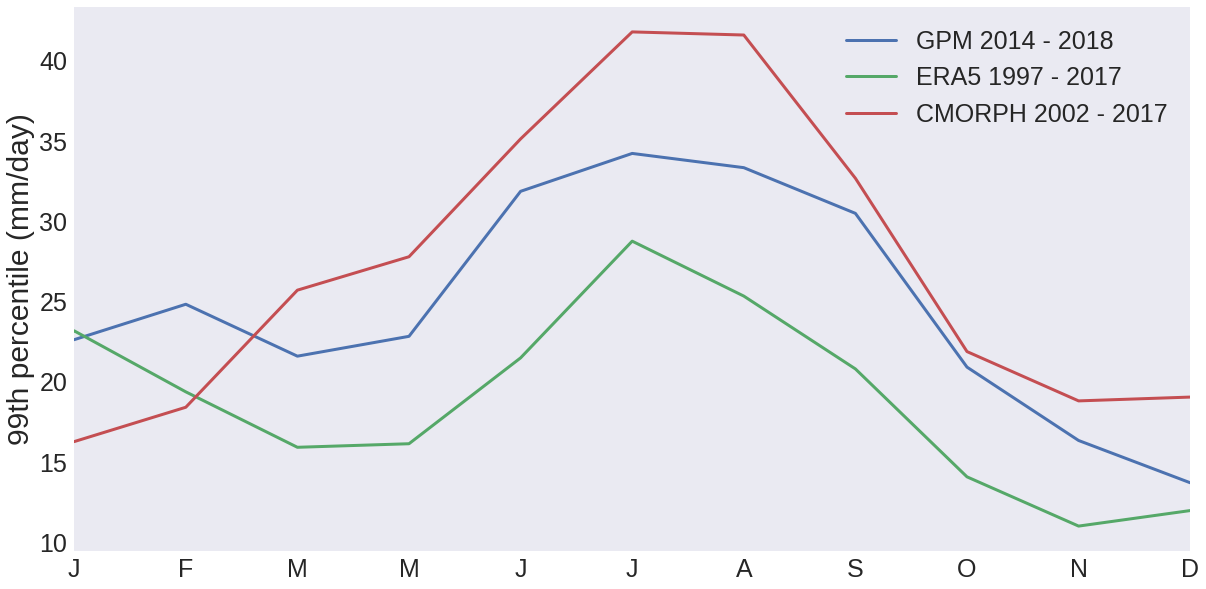

In [88]:
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 25,
                     'xtick.labelsize' : 25,
                     'ytick.labelsize' : 25})
plt.figure(figsize=(20, 10))
plt.ylabel('99th percentile (mm/day)', fontsize= 30)
labels= ['J', 'F', 'M','M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
plt.xticks(np.arange(1,12,1), labels)
plt.grid()
plt.xlim(1,11)
plt.plot(percentiles[1::], linewidth= '3', label='GPM 2014 - 2018')
plt.plot(percentiles_era[1::], linewidth= '3', label='ERA5 1997 - 2017')
plt.plot(percentiles_cmorph[1::], linewidth= '3', label='CMORPH 2002 - 2017')
#plt.plot(percentiles_mswep[1::], linewidth= '3', label= 'MSWEP 1997 - 2016')
plt.legend( prop={'size': 25})
#plt.show()
plt.rcParams.update({'font.size': 30})


plt.savefig('/media/juli/Elements/comparison/datasets_seasonal_extremeprecip_percentiles.pdf')



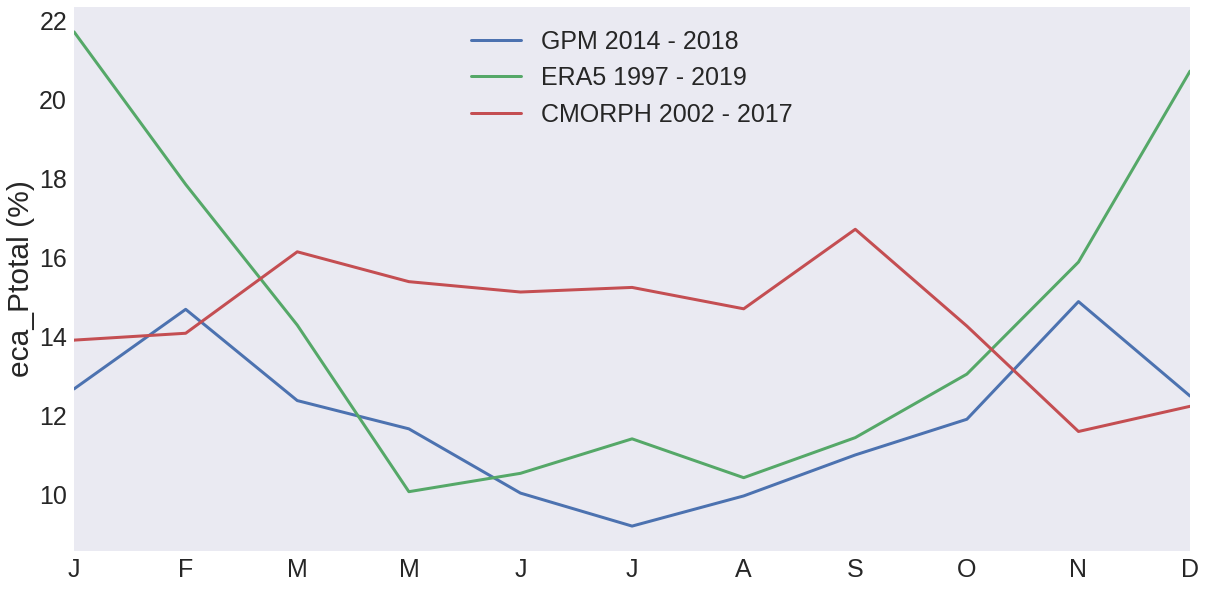

In [89]:
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 25,
                     'xtick.labelsize' : 25,
                     'ytick.labelsize' : 25})
plt.figure(figsize=(20, 10))
plt.ylabel('eca_Ptotal (%)', fontsize= 30)
labels= ['J', 'F', 'M','M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
plt.xticks(np.arange(1,12,1), labels)
plt.grid()
plt.xlim(1,11)
plt.plot(percentages[1::], linewidth= '3', label='GPM 2014 - 2018')
plt.plot(percentages_era[1::], linewidth= '3', label='ERA5 1997 - 2019')
plt.plot(percentages_cmorph[1::], linewidth= '3', label='CMORPH 2002 - 2017')
#plt.plot(mswep_percentages[1::], linewidth= '3', label= 'MSWEP 1997 - 2016')
plt.legend( prop={'size': 25})
#plt.show()
plt.rcParams.update({'font.size': 30})


plt.savefig('/media/juli/Elements/comparison/datasets_extremeprecip_ecaptot.pdf')


## Grid plot GPM

In [17]:
# read in grid with 99th percentile (all year)

file = '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/prec99_summer.nc4'
filename= 'prec90_summer.nc4'
prec, lons_gpm, lats_gpm, date, time= read_in_netcdf(file, filename)
prec90_gpm=  prec[0,:]

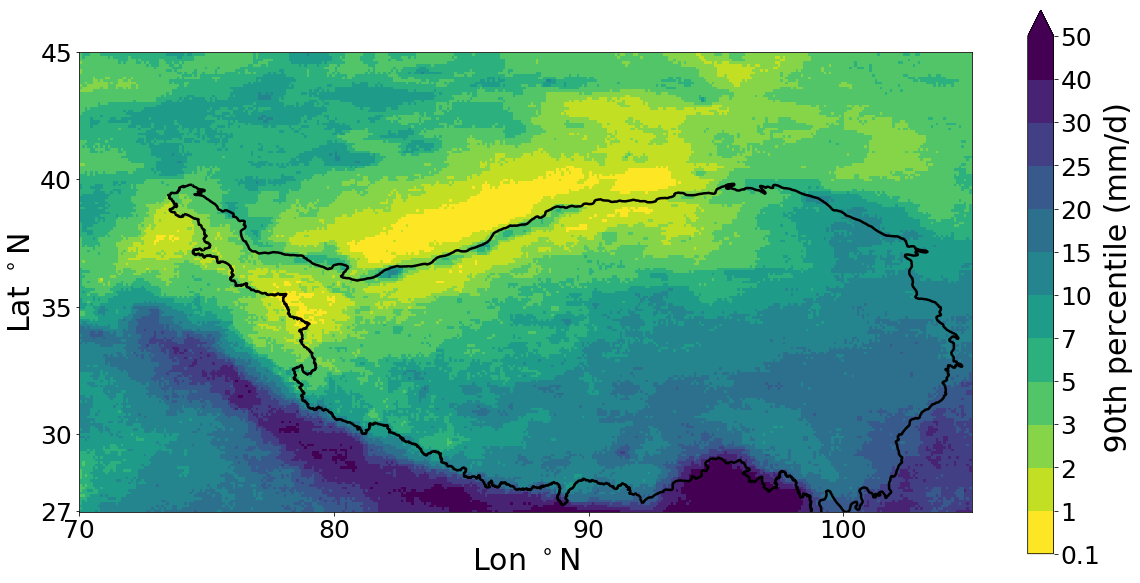

In [20]:
plt.figure(figsize=(20, 10))

cmap = plt.cm.get_cmap('viridis_r')
bounds= np.array([0.1, 1 , 2, 3, 5, 7, 10, 15, 20,25,  30, 40, 50])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors= 256)

m = Basemap(projection='cyl', llcrnrlat=26.95,urcrnrlat=44.95, llcrnrlon=70.05, urcrnrlon=105.05,  resolution = 'c')
#m = Basemap(width=4000000,height=3000000,resolution='l', projection='aea',lat_1=27.,lat_2=45,lon_0=90, lat_0= (45+27)/2)

lon, lat =np.meshgrid(lons_gpm[:,0], lats_gpm[0,:])
xi,yi = m(lon,lat)
cs = m.pcolormesh(xi,yi, prec90_gpm.T, cmap=cmap, norm = norm, vmin= 0.1, vmax = 50 )
cmap.set_under(color='lightyellow')

xlabels=[70, 80, 90, 100]
ylabels= [ 27, 30, 35, 40, 45]

plt.xticks([70, 80,90, 100], xlabels, fontsize=25)
plt.yticks([27,30, 35, 40, 45],ylabels, fontsize=25)
plt.xlabel('Lon $^\circ$N',  fontsize=30)
plt.ylabel('Lat $^\circ$N',  fontsize=30)

# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=2.5)


cbar = plt.colorbar(extend= 'max')
cbar.set_label(' 90th percentile (mm/d)', fontsize= 30)
cbar.set_ticks(bounds)
labels = ['0.1', '1', '2', '3', '5', '7', '10', '15', '20','25', '30', '40', '50']
cbar.set_ticklabels(labels)

plt.rcParams.update({'font.size': 25})

plt.savefig('/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/tracks/plots/gpm_extremeprecip_90percentiles_grid.png')





## MSWEP grid plot

In [21]:
def read_in_netcdf_mswep(file):
    dataset = Dataset(file)    
    prec= np.array(dataset["precipitation"])
    lon= np.array(dataset["lon"])
    lat= np.array(dataset["lat"])
    dataset.close()
    return prec, lon, lat
    

In [42]:
# read in grid with 99th percentile (all year)

#file = '/media/juli/Elements/MSWEP/MSWEP/daily/2014_2017/prec90_20142017summer.nc'
file = '/media/juli/Elements/MSWEP/MSWEP/daily/prec90_summer.nc'
prec, lons, lats = read_in_netcdf_mswep(file)
prec90_mswep= prec[0,:]


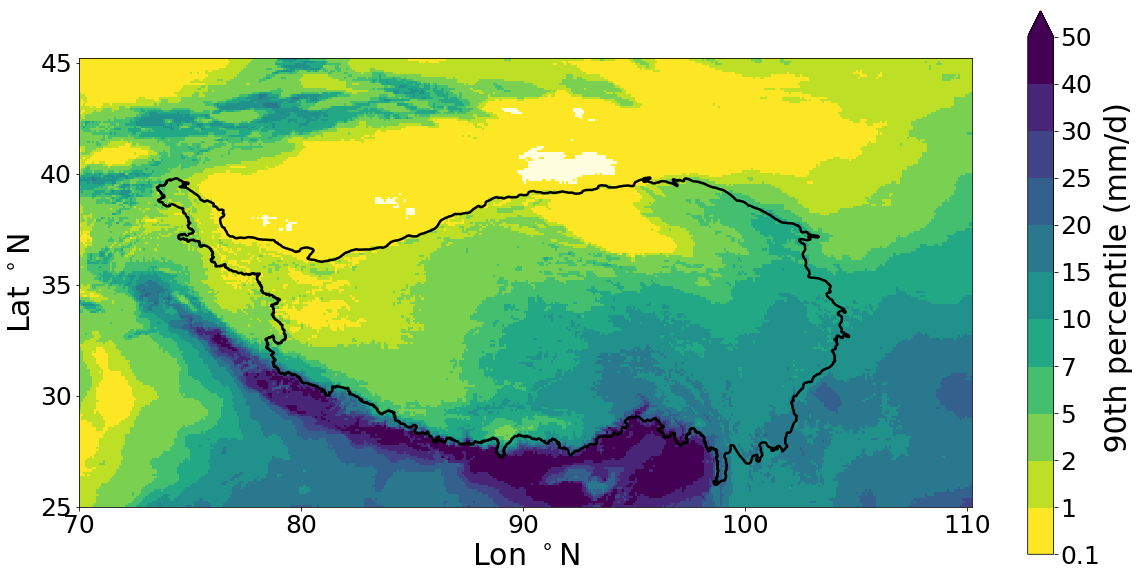

In [43]:
plt.figure(figsize=(20, 10))

cmap = plt.cm.get_cmap('viridis_r')
bounds= np.array([ 0.1, 1,2,  5, 7, 10, 15, 20,25,  30, 40, 50])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors= 256)

m = Basemap(projection='cyl', llcrnrlat=25,urcrnrlat=45.2, llcrnrlon=70, urcrnrlon=110.2,  resolution = 'c')
#m = Basemap(width=4000000,height=3000000,resolution='l', projection='aea',lat_1=27.,lat_2=45,lon_0=90, lat_0= (45+27)/2)

lon, lat =np.meshgrid(lons, lats)
xi,yi = m(lon,lat)
cs = m.pcolormesh(xi,yi, prec90_mswep, cmap=cmap, norm = norm, vmin= 0.1, vmax = 60)
cmap.set_under(color='lightyellow')

xlabels=[70, 80, 90, 100, 110]
ylabels= [ 25, 30, 35, 40, 45]

plt.xticks([70, 80,90, 100, 110], xlabels, fontsize=25)
plt.yticks([25,30, 35, 40, 45],ylabels, fontsize=25)
plt.xlabel('Lon $^\circ$N', fontsize= 30)
plt.ylabel('Lat $^\circ$N', fontsize= 30)

# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=2.5)


cbar = plt.colorbar(extend= 'max')
cbar.set_label(' 90th percentile (mm/d)', fontsize= 30
              )
cbar.set_ticks(bounds)
labels = ['0.1','1', '2', '5', '7', '10', '15', '20', '25', '30', '40', '50']
cbar.set_ticklabels(labels)

plt.rcParams.update({'font.size': 25})


plt.savefig('/media/juli/Elements/MSWEP/MSWEP/daily/mswep_extremeprecip_90percentiles_grid.png')

## Grid plots all four datasets 

In [31]:
file = '/media/juli/Elements/ERA5/daily/1997_2017/prec90_summer.nc'
file2 = '/media/juli/Elements/CMORPH/daily/prec90_summer.nc'


prec_era, lons_era, lats_era = read_in_netcdf_era(file)
prec_cmorph, lons_cmorph, lats_cmorph= read_in_netcdf_cmorph(file2)

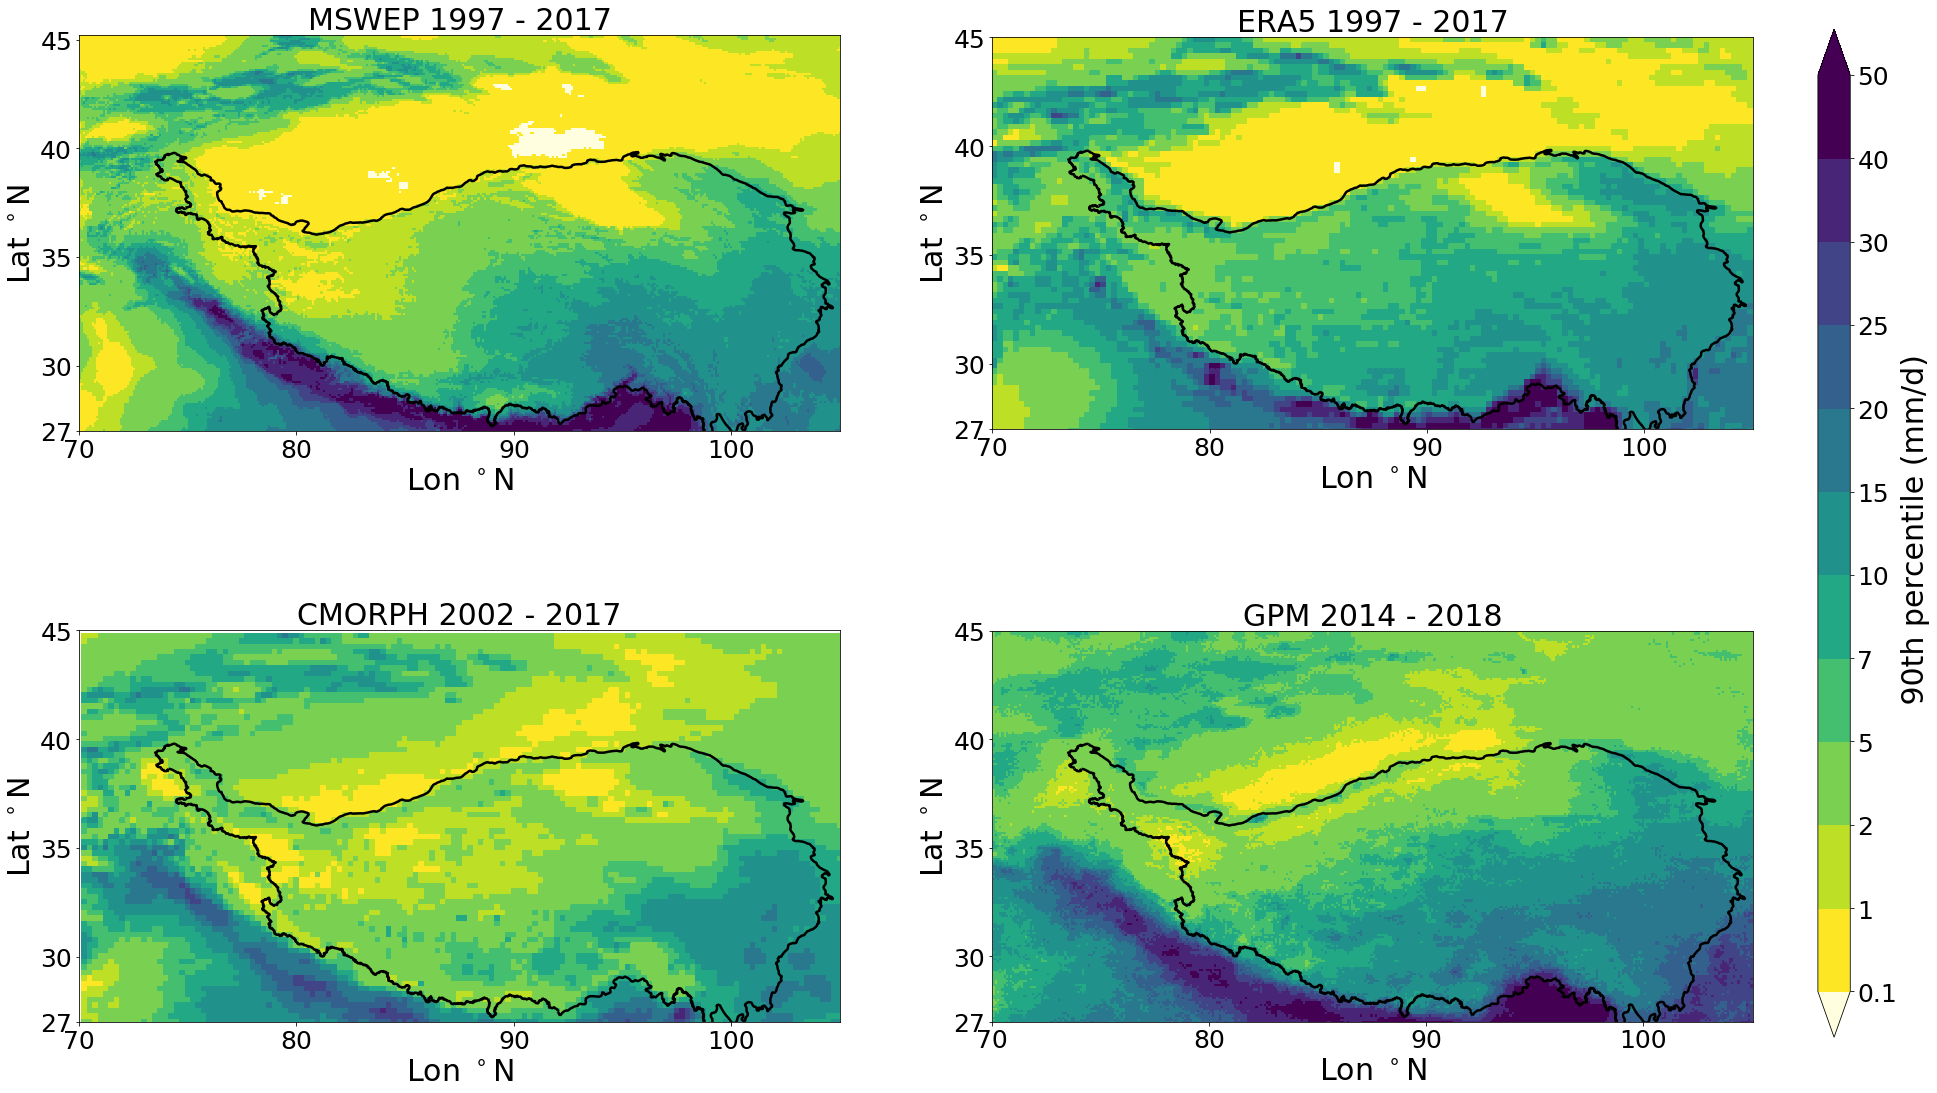

In [47]:
#fig = plt.figure(figsize= (30,20))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 20))

bounds= np.array([ 0.1, 1,2,  5, 7, 10, 15, 20, 25, 30, 40, 50])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors= 256)


plt.subplot(221)
plt.title('MSWEP 1997 - 2017')
m = Basemap(projection='cyl', llcrnrlat=27,urcrnrlat=45.2, llcrnrlon=70, urcrnrlon=105,  resolution = 'c')

lon, lat =np.meshgrid(lons, lats)
xi,yi = m(lon,lat)
cs = m.pcolormesh(xi,yi, prec90_mswep, cmap=cmap, norm = norm, vmin= 0.1, vmax = 50)
cmap.set_under(color='lightyellow')

xlabels=[70, 80, 90, 100]
ylabels= [ 27, 30, 35, 40, 45]

plt.xticks([70, 80,90, 100], xlabels, fontsize=25)
plt.yticks([27,30, 35, 40, 45],ylabels, fontsize=25)
plt.xlabel('Lon $^\circ$N', fontsize= 30)
plt.ylabel('Lat $^\circ$N', fontsize= 30)

# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=2.5)


plt.subplot(222)
plt.title('ERA5 1997 - 2017')
m = Basemap(projection='cyl', llcrnrlat=27,urcrnrlat=np.max(lats_era), llcrnrlon=np.min(lons_era), urcrnrlon=np.max(lons_era),  resolution = 'c')

lon, lat =np.meshgrid(lons_era, lats_era)
xi,yi = m(lon,lat)
cs = m.pcolormesh(xi,yi, prec_era, cmap=cmap, norm = norm, vmin= 0.1, vmax = 50 )
cmap.set_under(color='lightyellow')

xlabels=[70, 80, 90, 100]
ylabels= [ 27, 30, 35, 40, 45]

plt.xticks([70, 80,90, 100], xlabels, fontsize=25)
plt.yticks([27,30, 35, 40, 45],ylabels, fontsize=25)
plt.xlabel('Lon $^\circ$N',  fontsize=30)
plt.ylabel('Lat $^\circ$N',  fontsize=30)

# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=2.5)





plt.subplot(223)
plt.title('CMORPH 2002 - 2017')
m = Basemap(projection='cyl', llcrnrlat=27,urcrnrlat=np.max(lats_cmorph), llcrnrlon=np.min(lons_cmorph), urcrnrlon=105,  resolution = 'c')

lon, lat =np.meshgrid(lons_cmorph, lats_cmorph)
xi,yi = m(lon,lat)
cs = m.pcolormesh(xi,yi, prec_cmorph, cmap=cmap, norm = norm, vmin= 0.1, vmax = 50 )
cmap.set_under(color='lightyellow')

xlabels=[70, 80, 90, 100]
ylabels= [ 27, 30, 35, 40, 45]

plt.xticks([70, 80,90, 100], xlabels, fontsize=25)
plt.yticks([27,30, 35, 40, 45],ylabels, fontsize=25)
plt.xlabel('Lon $^\circ$N',  fontsize=30)
plt.ylabel('Lat $^\circ$N',  fontsize=30)

# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=2.5)



plt.subplot(224)
plt.title('GPM 2014 - 2018')
m = Basemap(projection='cyl', llcrnrlat=27,urcrnrlat=44.95, llcrnrlon=70.05, urcrnrlon=105.05,  resolution = 'c')

lon, lat =np.meshgrid(lons_gpm[:,0], lats_gpm[0,:])
xi,yi = m(lon,lat)
cs = m.pcolormesh(xi,yi, prec90_gpm.T, cmap=cmap, norm = norm, vmin= 0.1, vmax = 50 )
cmap.set_under(color='lightyellow')

xlabels=[70, 80, 90, 100]
ylabels= [ 27, 30, 35, 40, 45]

plt.xticks([70, 80,90, 100], xlabels, fontsize=25)
plt.yticks([27,30, 35, 40, 45],ylabels, fontsize=25)
plt.xlabel('Lon $^\circ$N',  fontsize=30)
plt.ylabel('Lat $^\circ$N',  fontsize=30)

# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=2.5)


## colorbar settings 
cb_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
cmap = plt.cm.get_cmap('viridis_r')


cbar = fig.colorbar(cs, extend= 'both', cax=cb_ax)
cbar.set_label(' 90th percentile (mm/d)', fontsize= 30)
cbar.set_ticks(bounds)
labels = ['0.1','1', '2', '5', '7', '10', '15', '20', '25', '30', '40', '50']
cbar.set_ticklabels(labels)

plt.rcParams.update({'font.size': 25})


# save figure to image file 
plt.savefig('/media/juli/Elements/comparison/datasets_95percentiles_grid.png')

In [125]:
file = '/media/juli/Elements/MSWEP/MSWEP/daily/MSWEP_summer_mean_1979_2017.nc'
file2 = '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/GPM_IMERG_summer_2014_2018.nc4'
file3= '/media/juli/Elements/CMORPH/daily/CMORPH_summer_2002_2017_mean.nc'
file4 = '/media/juli/Elements/ERA5/daily/1997_2017/era_daily_summer_1997_2017_mean.nc'


gpm, lons, lats, date, time = read_in_netcdf(file2, filename)
cmorph, lons, lats = read_in_netcdf_cmorph(file3)
era, lons, lats = read_in_netcdf_era(file4)
mswep, lons, lats = read_in_netcdf_mswep(file)
gpm= gpm[0,:]
mswep= mswep[0,:]

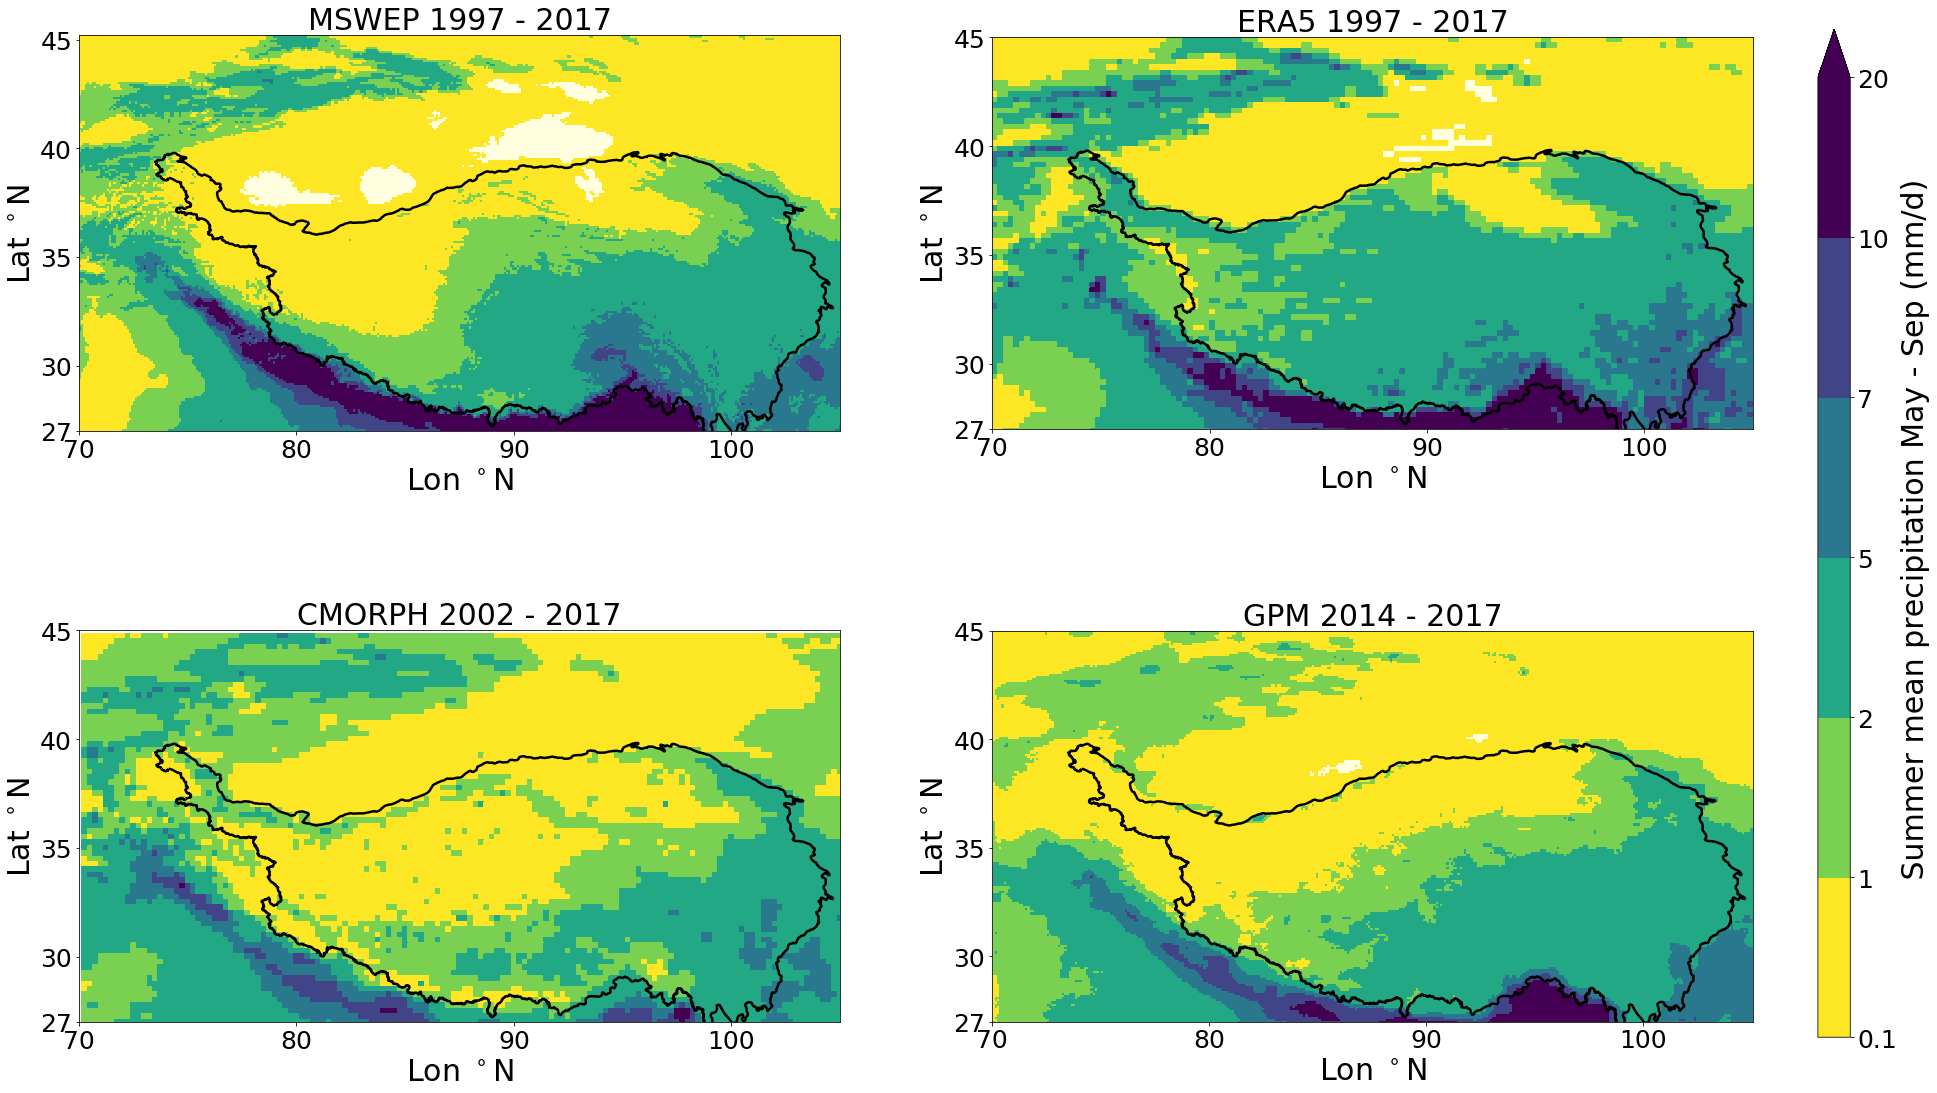

In [151]:
#fig = plt.figure(figsize= (30,20))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 20))

## colorbar settings 
cb_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
cmap = plt.cm.get_cmap('viridis_r')
bounds= np.array([ 0.1, 1,2,  5, 7, 10, 20 ])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors= 256)


plt.subplot(221)
plt.title('MSWEP 1997 - 2017')
m = Basemap(projection='cyl', llcrnrlat=27,urcrnrlat=45.2, llcrnrlon=70, urcrnrlon=105,  resolution = 'c')

lon, lat =np.meshgrid(lons, lats)
xi,yi = m(lon,lat)
cs = m.pcolormesh(xi,yi, mswep, cmap=cmap, norm = norm, vmin= 0.1, vmax = 10)
cmap.set_under(color='lightyellow')

xlabels=[70, 80, 90, 100]
ylabels= [ 27, 30, 35, 40, 45]

plt.xticks([70, 80,90, 100], xlabels, fontsize=25)
plt.yticks([27,30, 35, 40, 45],ylabels, fontsize=25)
plt.xlabel('Lon $^\circ$N', fontsize= 30)
plt.ylabel('Lat $^\circ$N', fontsize= 30)

# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=2.5)


plt.subplot(222)
plt.title('ERA5 1997 - 2017')
m = Basemap(projection='cyl', llcrnrlat=27,urcrnrlat=np.max(lats_era), llcrnrlon=np.min(lons_era), urcrnrlon=np.max(lons_era),  resolution = 'c')

lon, lat =np.meshgrid(lons_era, lats_era)
xi,yi = m(lon,lat)
cs = m.pcolormesh(xi,yi, era, cmap=cmap, norm = norm, vmin= 0.1, vmax = 10 )
cmap.set_under(color='lightyellow')

xlabels=[70, 80, 90, 100]
ylabels= [ 27, 30, 35, 40, 45]

plt.xticks([70, 80,90, 100], xlabels, fontsize=25)
plt.yticks([27,30, 35, 40, 45],ylabels, fontsize=25)
plt.xlabel('Lon $^\circ$N',  fontsize=30)
plt.ylabel('Lat $^\circ$N',  fontsize=30)

# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=2.5)





plt.subplot(223)
plt.title('CMORPH 2002 - 2017')
m = Basemap(projection='cyl', llcrnrlat=27,urcrnrlat=np.max(lats_cmorph), llcrnrlon=np.min(lons_cmorph), urcrnrlon=105,  resolution = 'c')

lon, lat =np.meshgrid(lons_cmorph, lats_cmorph)
xi,yi = m(lon,lat)
cs = m.pcolormesh(xi,yi, cmorph, cmap=cmap, norm = norm, vmin= 0.1, vmax = 10 )
cmap.set_under(color='lightyellow')

xlabels=[70, 80, 90, 100]
ylabels= [ 27, 30, 35, 40, 45]

plt.xticks([70, 80,90, 100], xlabels, fontsize=25)
plt.yticks([27,30, 35, 40, 45],ylabels, fontsize=25)
plt.xlabel('Lon $^\circ$N',  fontsize=30)
plt.ylabel('Lat $^\circ$N',  fontsize=30)

# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=2.5)



plt.subplot(224)
plt.title('GPM 2014 - 2017')
m = Basemap(projection='cyl', llcrnrlat=27,urcrnrlat=44.95, llcrnrlon=70.05, urcrnrlon=105.05,  resolution = 'c')

lon, lat =np.meshgrid(lons_gpm[:,0], lats_gpm[0,:])
xi,yi = m(lon,lat)
cs = m.pcolormesh(xi,yi, gpm.T, cmap=cmap, norm = norm, vmin= 0.1, vmax = 10 )
cmap.set_under(color='lightyellow')

xlabels=[70, 80, 90, 100]
ylabels= [ 27, 30, 35, 40, 45]

plt.xticks([70, 80,90, 100], xlabels, fontsize=25)
plt.yticks([27,30, 35, 40, 45],ylabels, fontsize=25)
plt.xlabel('Lon $^\circ$N',  fontsize=30)
plt.ylabel('Lat $^\circ$N',  fontsize=30)

# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=2.5)




cbar = fig.colorbar(cs, extend= 'max', cax=cb_ax)
cbar.set_label(' Summer mean precipitation May - Sep (mm/d)', fontsize= 30)
cbar.set_ticks(bounds)
labels = ['0.1','1', '2', '5', '7', '10', '20']
cbar.set_ticklabels(labels)

plt.rcParams.update({'font.size': 25})


# save figure to image file 
plt.savefig('/media/juli/Elements/comparison/datasets_summermean_grids.png')

## CMORPH: monthly extreme precipitation 

In [112]:
def read_in_netcdf_cmorph(file):
    dataset = Dataset(file)    
    prec= np.array(dataset["cmorph_precip"])[0,:]
    lon= np.array(dataset["lon"])
    lat= np.array(dataset["lat"])
    dataset.close()
    return prec, lon, lat

In [113]:
# This function creates a dictionary containing all hourly files within one month, keys are month for year and values are the corresponding files 
def create_dic():  
    files={}
    keys=[]
    values=[]
    working_dir= '/media/juli/Elements/CMORPH/daily/'
    
    for month in np.arange(1,13,1):
        if month < 10:
            k = '0'+str(month)
            keys.append(k)
            values.append(glob.glob(working_dir + 'cmorph_????'  + str(k) + '*daily_acc_prec_mmhr.nc'))           
        else:
            k = str(month)
            keys.append(k)
            values.append(glob.glob(working_dir + 'cmorph_????' + str(k) + '*daily_acc_prec_mmhr.nc'))

    ## populate dictionary with keys and values 
    files= dict(zip(keys, values))
    cmorph = files 
    return cmorph

In [114]:
cmorph= create_dic()


In [85]:
# main loop to create files with monthly rain rate values 
for month in cmorph.keys():
    rr= np.empty([])
    for f in cmorph[month]:
        prec, lons, lats = read_in_netcdf_cmorph(f)
        prec[dem_cmorph3 < 3000 ]= 0
        rr= extract_rain_rates(prec, rr)
        
    # save parameter to text file after having looped through all daily files 
    np.savetxt('/media/juli/Elements/CMORPH/daily/cmorph_monthly_rr_' + month + '2002_2017.csv', rr, delimiter=",")
    print('....files created with  ', np.shape(rr), '  values in month  ', month)

....files created with   (176339,)   values in month   01
....files created with   (266109,)   values in month   02
....files created with   (428873,)   values in month   03
....files created with   (540473,)   values in month   04
....files created with   (622091,)   values in month   05
....files created with   (634219,)   values in month   06
....files created with   (663647,)   values in month   07
....files created with   (605503,)   values in month   08
....files created with   (520378,)   values in month   09
....files created with   (367770,)   values in month   10
....files created with   (276341,)   values in month   11
....files created with   (226782,)   values in month   12


In [109]:
# read in created text files and calculate monthly 99-percentiles in each dataset 

from numpy import genfromtxt
percentiles_cmorph = np.empty([])
all_values_cmorph = np.empty([])

for month in cmorph.keys():
    monthly_rr = genfromtxt('/media/juli/Elements/CMORPH/daily/cmorph_monthly_rr_' + month + '2002_2016.csv', delimiter=',')
    all_values_cmorph = np.append(all_values_cmorph, monthly_rr)
    monthly_p= np.nanpercentile(monthly_rr, 99) 
    print(month, np.shape(monthly_rr), monthly_p)
    percentiles_cmorph= np.append(percentiles_cmorph, monthly_p)


# save parameter to text file after having looped through all daily files 
np.savetxt('/media/juli/Elements/CMORPH/daily/monthly_percentiles.csv', percentiles, delimiter=",")

01 (176339,) 17.29052932739259
02 (266109,) 16.285167503356796
03 (428873,) 18.424995975494383
04 (540473,) 25.718276538849082
05 (622091,) 27.799999237060547
06 (634219,) 35.14024692535365
07 (663647,) 41.80458774566689
08 (605503,) 41.61100353240956
09 (520378,) 32.68888854980469
10 (367770,) 21.892389678955087
11 (276341,) 18.82086717605586
12 (226782,) 19.05833435058606


In [87]:
percentages_cmorph= np.empty([])
i= 1 

for month in cmorph.keys():
    print('....calculating ecaptot for month   ',month)
    total_rr= 0 
    rr99= 0 
    for f in cmorph[month]:
        prec, lons, lats= read_in_netcdf_cmorph(f)
        #prec = prec[0,:]
        prec[dem_cmorph3 < 3000 ]= np.nan
        pp = percentiles_cmorph[i]
        total_rr, rr99= eca_ptot(prec, total_rr, rr99, pp)
    i+= 1
    ecaptot= np.divide(rr99, total_rr)*100
    percentages_cmorph= np.append(percentages_cmorph, ecaptot)
    
# save parameter to text file after having looped through all daily files 
np.savetxt('/media/juli/Elements/CMORPH/daily/monthly_ecaptot.csv', percentages, delimiter=",")

....calculating ecaptot for month    01
....calculating ecaptot for month    02
....calculating ecaptot for month    03
....calculating ecaptot for month    04
....calculating ecaptot for month    05
....calculating ecaptot for month    06
....calculating ecaptot for month    07
....calculating ecaptot for month    08
....calculating ecaptot for month    09
....calculating ecaptot for month    10
....calculating ecaptot for month    11
....calculating ecaptot for month    12


## ERA 5  : monthly extreme precipitation 

In [27]:
def read_in_netcdf_era(file):
    dataset = Dataset(file)    
    prec= np.array(dataset["tp"])[0,:]
    lon= np.array(dataset["longitude"])
    lat= np.array(dataset["latitude"])
    dataset.close()
    return prec, lon, lat

In [53]:
# This function creates a dictionary containing all hourly files within one month, keys are month for year and values are the corresponding files 
def create_dic():  
    files={}
    keys=[]
    values=[]
    working_dir= '/media/juli/Elements/ERA5/daily/1997_2017/'
    
    for month in np.arange(1,13,1):
        if month < 10:
            k = '0'+str(month)
            keys.append(k)
            values.append(glob.glob(working_dir + 'era_????'  + str(k) + '*daily_acc*.nc'))           
        else:
            k = str(month)
            keys.append(k)
            values.append(glob.glob(working_dir + 'era_????' + str(k) + '*daily_acc*.nc'))

    ## populate dictionary with keys and values 
    files= dict(zip(keys, values))
    era = files 
    return era

In [55]:
era= create_dic()


In [59]:
# read in created text files and calculate monthly 99-percentiles in each dataset 

from numpy import genfromtxt
percentiles_era = np.empty([])
all_values = np.empty([])

for month in era.keys():
    monthly_rr = genfromtxt('/media/juli/Elements/ERA5/daily/era_monthly_rr_' + month + '1997_2017.csv', delimiter=',')
    all_values = np.append(all_values, monthly_rr)
    monthly_p= np.nanpercentile(monthly_rr, 99) 
    print(month, np.shape(monthly_rr), monthly_p)
    percentiles_era= np.append(percentiles_era, monthly_p)
    

# save parameter to text file after having looped through all daily files 
np.savetxt('/media/juli/Elements/ERA5/daily/monthly_percentiles.csv', percentiles, delimiter=",")

01 (859035,) 16.525531496549156
02 (973643,) 23.184596490381836
03 (1126007,) 19.38433751279474
04 (1218756,) 15.930689646287277
05 (1515621,) 16.152221361044155
06 (1691886,) 21.500579015314354
07 (1886432,) 28.770772667851467
08 (1847085,) 25.349019231646736
09 (1551135,) 20.813002791919732
10 (1082798,) 14.0898094417655
11 (677627,) 11.022274026996879
12 (697501,) 11.989757439815438


In [69]:
percentages_era= np.empty([])
i= 1 

for month in era.keys():
    print('....calculating ecaptot for month   ',month)
    total_rr= 0 
    rr99= 0 
    for f in era[month]:
        prec, lons, lats= read_in_netcdf_era(f)
        #prec = prec[0,:]
        prec[dem_era < 3000 ]= np.nan
        pp = percentiles_era[i]
        total_rr, rr99= eca_ptot(prec, total_rr, rr99, pp)
    i+= 1
    ecaptot= np.divide(rr99, total_rr)*100
    percentages_era= np.append(percentages_era, ecaptot)
    
# save parameter to text file after having looped through all daily files 
np.savetxt('/media/juli/Elements/ERA5/daily/monthly_ecaptot.csv', percentages, delimiter=",")

....calculating ecaptot for month    01
....calculating ecaptot for month    02
....calculating ecaptot for month    03
....calculating ecaptot for month    04
....calculating ecaptot for month    05
....calculating ecaptot for month    06
....calculating ecaptot for month    07
....calculating ecaptot for month    08
....calculating ecaptot for month    09
....calculating ecaptot for month    10
....calculating ecaptot for month    11
....calculating ecaptot for month    12


In [182]:
# main loop to create files with monthly rain rate values 
for month in era.keys():
    rr= np.empty([])
    for f in era[month]:
        prec, lons, lats = read_in_netcdf_era(f)
        prec = prec[0,:]
        prec[dem_era < 3000 ]= 0
        rr= extract_rain_rates(prec, rr)
        
    # save parameter to text file after having looped through all daily files 
    np.savetxt('/media/juli/Elements/ERA5/daily/era_monthly_rr_' + month + '1997_2016.csv', rr, delimiter=",")
    print('....files created with  ', np.shape(rr), '  values in month  ', month)

ValueError: Expected 1D or 2D array, got 0D array instead

## MSWEP: Monthly extreme precipitation 

In [49]:
# This function creates a dictionary containing all hourly files within one month, keys are month for year and values are the corresponding files 
def create_dic():  
    files={}
    keys=[]
    values=[]
    working_dir= '/media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/'
    
    for month in np.arange(1,13,1):
        if month < 10:
            k = '0'+str(month)
            keys.append(k)
            values.append(glob.glob(working_dir + 'MSWEP_????' + str(k) + '*daily_acc*.nc'))
        else:
            k = str(month)
            keys.append(k)
            values.append(glob.glob(working_dir + 'MSWEP_????' + str(k) + '*daily_acc*.nc'))

    ## populate dictionary with keys and values 
    files= dict(zip(keys, values))
    mswep = files 
    return mswep

In [50]:
mswep= create_dic()
mswep

{'01': ['/media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19970101_daily_acc_prec.nc',
  '/media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19970102_daily_acc_prec.nc',
  '/media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19970103_daily_acc_prec.nc',
  '/media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19970104_daily_acc_prec.nc',
  '/media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19970105_daily_acc_prec.nc',
  '/media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19970106_daily_acc_prec.nc',
  '/media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19970107_daily_acc_prec.nc',
  '/media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19970108_daily_acc_prec.nc',
  '/media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19970109_daily_acc_prec.nc',
  '/media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19970110_daily_acc_prec.nc',
  '/media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19970111_daily_acc_prec.nc',
  '/media/juli/Elements/MSWEP/MSWEP/d

In [ ]:
# main loop to create files with monthly rain rate values 
for month in list(mswep.keys())[3::]:
    rr= np.empty([])
    for f in mswep[month]:
        print(month, f)
        prec, lons, lats = read_in_netcdf_mswep(f)
        prec = prec[0,:]
        prec[dem_out < 3000 ]= 0
        rr= extract_rain_rates(prec, rr)
        
    # save parameter to text file after having looped through all daily files 
    np.savetxt('/media/juli/Elements/MSWEP/MSWEP/daily/mswep_monthly_rr_' + month + '1997_2016.csv', rr, delimiter=",")
    print('....files created with  ', np.shape(rr), '  values in month  ', month)

04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19970408_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19970422_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19970401_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19970402_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19970403_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19970404_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19970405_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19970406_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19970407_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19970409_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19970410_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_1997041

04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20000409_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20000410_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20000411_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20000412_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20000413_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20000414_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20000415_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20000416_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20000417_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20000419_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20000420_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_2000042

04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20030417_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20030418_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20030419_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20030420_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20030421_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20030422_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20030423_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20030424_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20030425_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20030426_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20030427_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_2003042

04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20060423_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20060424_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20060426_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20060427_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20060428_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20060429_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20060430_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20060411_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20060425_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20070401_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20070402_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_2007040

04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20090407_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20090421_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20100401_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20100402_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20100403_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20100404_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20100405_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20100407_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20100408_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20100409_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20100410_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_2010041

04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20130407_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20130408_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20130409_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20130410_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20130411_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20130412_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20130413_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20130414_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20130415_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20130417_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20130418_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_2013041

04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20160414_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20160415_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20160416_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20160417_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20160418_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20160419_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20160420_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20160421_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20160422_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20160423_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20160424_daily_acc_prec.nc
04 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_2016042

05 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19990519_daily_acc_prec.nc
05 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19990520_daily_acc_prec.nc
05 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19990521_daily_acc_prec.nc
05 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19990522_daily_acc_prec.nc
05 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19990523_daily_acc_prec.nc
05 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19990524_daily_acc_prec.nc
05 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19990525_daily_acc_prec.nc
05 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19990526_daily_acc_prec.nc
05 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19990527_daily_acc_prec.nc
05 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19990528_daily_acc_prec.nc
05 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_19990529_daily_acc_prec.nc
05 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_1999053

05 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20020522_daily_acc_prec.nc
05 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20020523_daily_acc_prec.nc
05 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20020524_daily_acc_prec.nc
05 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20020525_daily_acc_prec.nc
05 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20020526_daily_acc_prec.nc
05 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20020527_daily_acc_prec.nc
05 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20020529_daily_acc_prec.nc
05 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20020530_daily_acc_prec.nc
05 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20020531_daily_acc_prec.nc
05 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20020514_daily_acc_prec.nc
05 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_20020528_daily_acc_prec.nc
05 /media/juli/Elements/MSWEP/MSWEP/daily/1997_2017/MSWEP_2003050

In [63]:
# read in created text files and calculate monthly 99-percentiles in each dataset 

percentiles_mswep = np.empty([])
all_values_mswep = np.empty([])

for month in files.keys():
    monthly_rr = genfromtxt('/media/juli/Elements/MSWEP/MSWEP/daily/mswep_monthly_rr_' + month + '1997_2016.csv', delimiter=',')
    all_values_mswep = np.append(all_values_mswep, monthly_rr)
    monthly_p= np.nanpercentile(monthly_rr, 99) 
    print(month, np.shape(monthly_rr), monthly_p)
    percentiles_mswep= np.append(percentiles_mswep, monthly_p)
    
# save parameter to text file after having looped through all daily files 
np.savetxt('/media/juli/Elements/MSWEP/MSWEP/daily/mswep_monthly_percentiles_1997_2016.csv', percentiles, delimiter=",")

01 (2171460,) 38.73999786376953
02 (2921892,) 44.220001220703125
03 (4558888,) 36.959999084472656
04 (6432099,) 34.540000915527344
05 (9087623,) 28.670000076293945
06 (10479171,) 31.3799991607666
07 (11408474,) 37.689998626708984
08 (11093466,) 34.720001220703125
09 (8494964,) 29.280000686645508
10 (4672810,) 28.059999465942383
11 (1978422,) 32.43000030517578
12 (1592779,) 32.04999923706055


In [80]:
# calculate percentage of precipitation above 99th percentile in relation to total average precipitation during month

mswep_percentages= np.empty([])
i= 1

for month in mswep.keys():
    print('....calculating ecaptot for month   ',month)
    total_rr= 0 
    rr99= 0 
    for f in mswep[month]:
        prec, lons, lats= read_in_netcdf_mswep(f)
        prec= prec[0,:]
        prec[dem_out < 3000 ]= 0
        pp = percentiles_mswep[i]
        total_rr, rr99= eca_ptot(prec, total_rr, rr99, pp)
    i+= 1
    ecaptot= np.divide(rr99, total_rr)*100
    mswep_percentages= np.append(mswep_percentages, ecaptot)
    
# save parameter to text file after having looped through all daily files 
np.savetxt('/media/juli/Elements/MSWEP/MSWEP/daily/mswep_monthly_ecaptot_1997_2016.csv', mswep_percentages, delimiter=",")

....calculating ecaptot for month    01
....calculating ecaptot for month    02
....calculating ecaptot for month    03
....calculating ecaptot for month    04
....calculating ecaptot for month    05
....calculating ecaptot for month    06
....calculating ecaptot for month    07
....calculating ecaptot for month    08
....calculating ecaptot for month    09
....calculating ecaptot for month    10
....calculating ecaptot for month    11
....calculating ecaptot for month    12


## DISTRIBUTION OF RAIN RATES IN THE DIFFERENT DATA SETS 

In [55]:
# distribution MSWEP 

mswep_dist= np.empty([])

for month in mswep.keys():
    print('...read in all values for month ', month)
    data = genfromtxt('/media/juli/Elements/MSWEP/MSWEP/daily/mswep_monthly_rr_' + month + '1997_2016.csv', delimiter=',')
    mswep_dist= np.append(mswep_dist, data)


...read in all values for month  01
...read in all values for month  02
...read in all values for month  03
...read in all values for month  04
...read in all values for month  05
...read in all values for month  06
...read in all values for month  07
...read in all values for month  08
...read in all values for month  09
...read in all values for month  10
...read in all values for month  11
...read in all values for month  12


In [60]:
# distribution GPM 

gpm_dist = np.empty([])

for month in files.keys():
    print('...read in all values for month ', month)
    data = genfromtxt('/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/monthly_rr_' + month + '.csv', delimiter=',')
    gpm_dist= np.append(gpm_dist, data)

...read in all values for month  01
...read in all values for month  02
...read in all values for month  03
...read in all values for month  04
...read in all values for month  05
...read in all values for month  06
...read in all values for month  07
...read in all values for month  08
...read in all values for month  09
...read in all values for month  10
...read in all values for month  11
...read in all values for month  12


In [115]:
# distribution CMOPRH

cmorph_dist = np.empty([])

for month in cmorph.keys():
    print('...read in all values for month ', month)
    data = genfromtxt('/media/juli/Elements/CMORPH/daily/cmorph_monthly_rr_' + month + '2002_2017.csv', delimiter=',')
    cmorph_dist= np.append(gpm_dist, data)

...read in all values for month  01
...read in all values for month  02
...read in all values for month  03
...read in all values for month  04
...read in all values for month  05
...read in all values for month  06
...read in all values for month  07
...read in all values for month  08
...read in all values for month  09
...read in all values for month  10
...read in all values for month  11
...read in all values for month  12


In [86]:
p_mswep

15.359999656677246

In [110]:
# total percentiles 
p_gpm= np.nanpercentile(all_values, 95)
p_mswep = np.nanpercentile(all_values_mswep, 95)
p_cmorph = np.nanpercentile(all_values_cmorph, 95)

In [102]:
mswep_dist = pd.Series(mswep_dist)
mswep_dist= mswep_dist.dropna()



In [1]:
import seaborn as sns

plt.figure(figsize=(20, 10))

plt.style.use('seaborn')
plt.rcParams.update({'font.size': 25,
                     'xtick.labelsize' : 25,
                     'ytick.labelsize' : 25})

plt.subplot(221)
binwidth= 1.0
# Draw the plot
bins = int(180/binwidth)
plt.hist(mswep_dist, bins = int(len(mswep_dist)/3600), color = 'darkblue', edgecolor = 'black', density=True, stacked = True )



plt.title('MSWEP 1997 - 2016', fontsize= 30)
plt.xlabel('Rain rate (mm/day)', size = 22)
plt.ylabel('Frequency', size= 22)
plt.xlim(0,25)
plt.ylim(0,1)


plt.axvline(p_mswep, color='k', linestyle='dashed', linewidth=2.0, label = '95th percentile')
plt.legend( loc = 'upper center', prop={'size': 20})


plt.subplot(222)
binwidth= 0.05
bins = int(180/binwidth)
plt.hist(gpm_dist, bins = int(len(gpm_dist)/3600), 
         color = 'darkblue', edgecolor = 'black', density=True, stacked = True)

plt.axvline(p_gpm, color='k', linestyle='dashed', linewidth=2.0, label = '95th percentile')
plt.legend( prop={'size': 20})
plt.title('GPM 2014 - 2018', fontsize= 30)

plt.xlabel('Rain rate (mm/day)', size = 22)
plt.ylabel('Frequency', size= 22)
plt.xlim(0,25)
plt.ylim(0,1)





plt.subplot(223)
binwidth= 0.05
bins = int(180/binwidth)
plt.hist(cmorph_dist, bins = int(len(gpm_dist)/3600), 
         color = 'darkblue', edgecolor = 'black', density=True, stacked = True)

plt.axvline(p_cmorph, color='k', linestyle='dashed', linewidth=2.0, label = '95th percentile')
plt.legend( prop={'size': 20})
plt.title('CMORPH 2002 - 2017', fontsize= 30)

plt.xlabel('Rain rate (mm/day)', size = 22)
plt.ylabel('Frequency', size= 22)
plt.xlim(0,25)
plt.ylim(0,1)


plt.tight_layout()
#plt.show()
plt.savefig('/media/juli/Elements/comparison/mswep_gpm_cmorph_distributions.pdf')

NameError: name 'plt' is not defined

## Extended analysis 

- compare to CNRR, ERA5, CMORPH and stations to get an idea which one is closer 
- look at distributions from hourly rain rates 
- additional data sets 



## Feedback after RCG seminar 

- 95th percentile grid plots (maybe only shorter time periods for other years as well)
- look at interannual variability of extreme precipitation 
- how many values between 0 and 0.1? 


## Climatological control plots

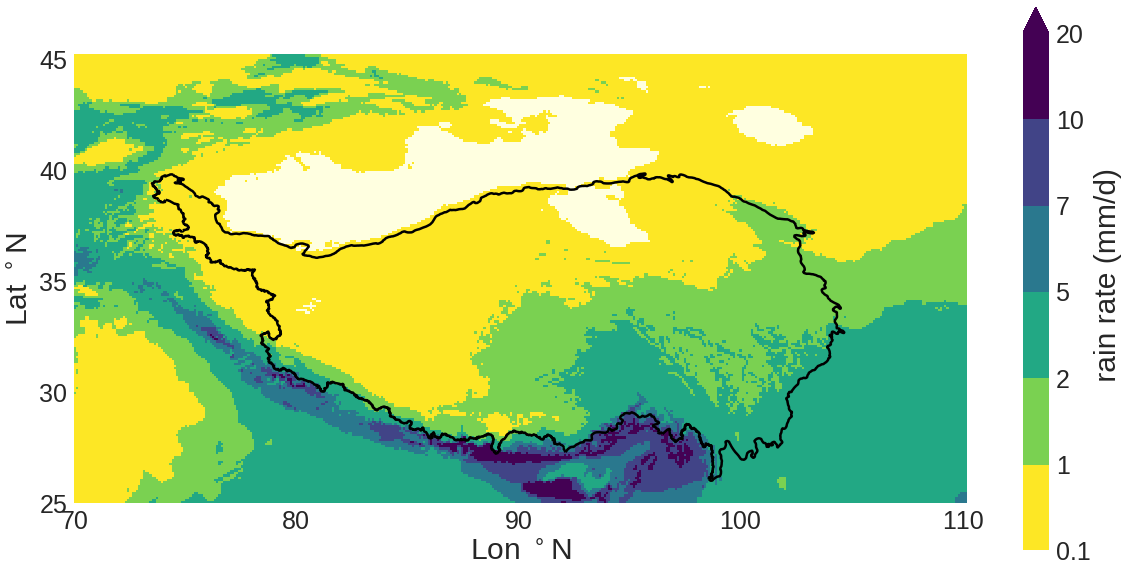

In [146]:
file= '/media/juli/Elements/MSWEP/MSWEP/daily/MSWEP_daily_1979_2017.nc'
prec, lon, lat = read_in_netcdf_mswep(file)
prec= prec[0,:]

plt.figure(figsize=(20, 10))

cmap = plt.cm.get_cmap('viridis_r')
bounds= np.array([ 0.1, 1,2,  5, 7, 10, 20])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors= 256)

m = Basemap(projection='cyl', llcrnrlat=25,urcrnrlat=45.2, llcrnrlon=70, urcrnrlon=110.2,  resolution = 'c')

lon, lat =np.meshgrid(lons, lats)
xi,yi = m(lon,lat)
cs = m.pcolormesh(xi,yi, prec, cmap=cmap, norm = norm, vmin= 0.1, vmax = 20)
cmap.set_under(color='lightyellow')

xlabels=[70, 80, 90, 100, 110]
ylabels= [ 25, 30, 35, 40, 45]

plt.xticks([70, 80,90, 100, 110], xlabels, fontsize=25)
plt.yticks([25,30, 35, 40, 45],ylabels, fontsize=25)
plt.xlabel('Lon $^\circ$N', fontsize= 30)
plt.ylabel('Lat $^\circ$N', fontsize= 30)

# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=2.5)


cbar = plt.colorbar(extend= 'max')
cbar.set_label(' rain rate (mm/d)', fontsize= 30
              )
cbar.set_ticks(bounds)
labels = ['0.1','1', '2', '5', '7', '10', '20']
cbar.set_ticklabels(labels)

plt.rcParams.update({'font.size': 25})


plt.savefig('/media/juli/Elements/MSWEP/MSWEP/daily/mswep_daily_avg_grid_1979_2018.png')


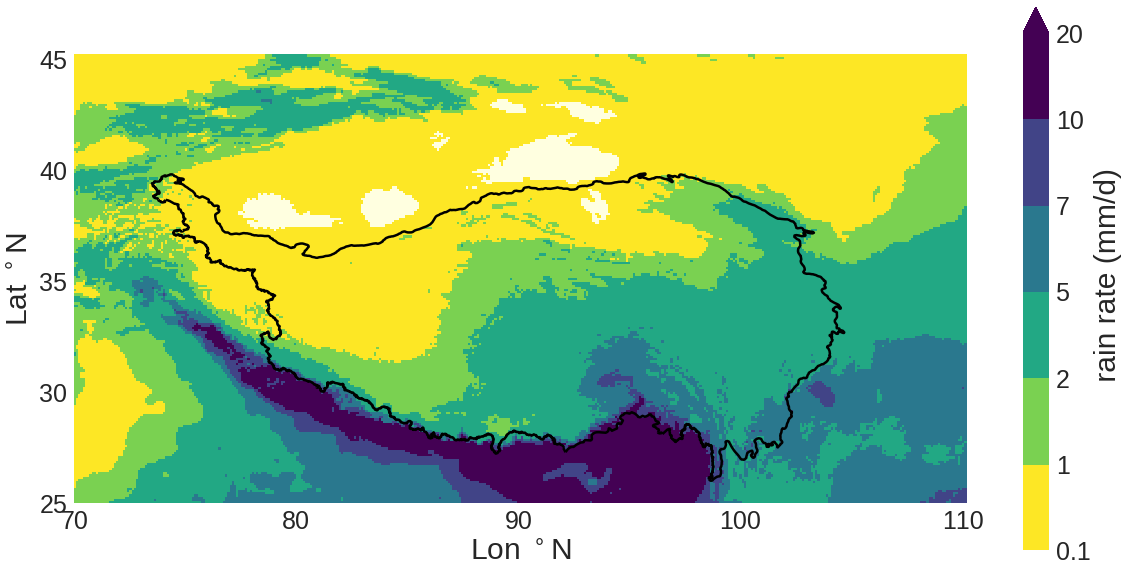

In [147]:
file= '/media/juli/Elements/MSWEP/MSWEP/daily/MSWEP_summer_mean_1979_2017.nc'
prec, lon, lat = read_in_netcdf_mswep(file)
prec= prec[0,:]

plt.figure(figsize=(20, 10))
cmap = plt.cm.get_cmap('viridis_r')
bounds= np.array([ 0.1, 1,2,  5, 7, 10, 20])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors= 256)

m = Basemap(projection='cyl', llcrnrlat=25,urcrnrlat=45.2, llcrnrlon=70, urcrnrlon=110.2,  resolution = 'c')

lon, lat =np.meshgrid(lons, lats)
xi,yi = m(lon,lat)
cs = m.pcolormesh(xi,yi, prec, cmap=cmap, norm = norm, vmin= 0.1, vmax = 20)
cmap.set_under(color='lightyellow')

xlabels=[70, 80, 90, 100, 110]
ylabels= [ 25, 30, 35, 40, 45]

plt.xticks([70, 80,90, 100, 110], xlabels, fontsize=25)
plt.yticks([25,30, 35, 40, 45],ylabels, fontsize=25)
plt.xlabel('Lon $^\circ$N', fontsize= 30)
plt.ylabel('Lat $^\circ$N', fontsize= 30)

# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=2.5)


cbar = plt.colorbar(extend= 'max')
cbar.set_label(' rain rate (mm/d)', fontsize= 30
              )
cbar.set_ticks(bounds)
labels = ['0.1','1', '2', '5', '7', '10', '20']
cbar.set_ticklabels(labels)

plt.rcParams.update({'font.size': 25})


plt.savefig('/media/juli/Elements/MSWEP/MSWEP/daily/mswep_summer_1979_2018.png')

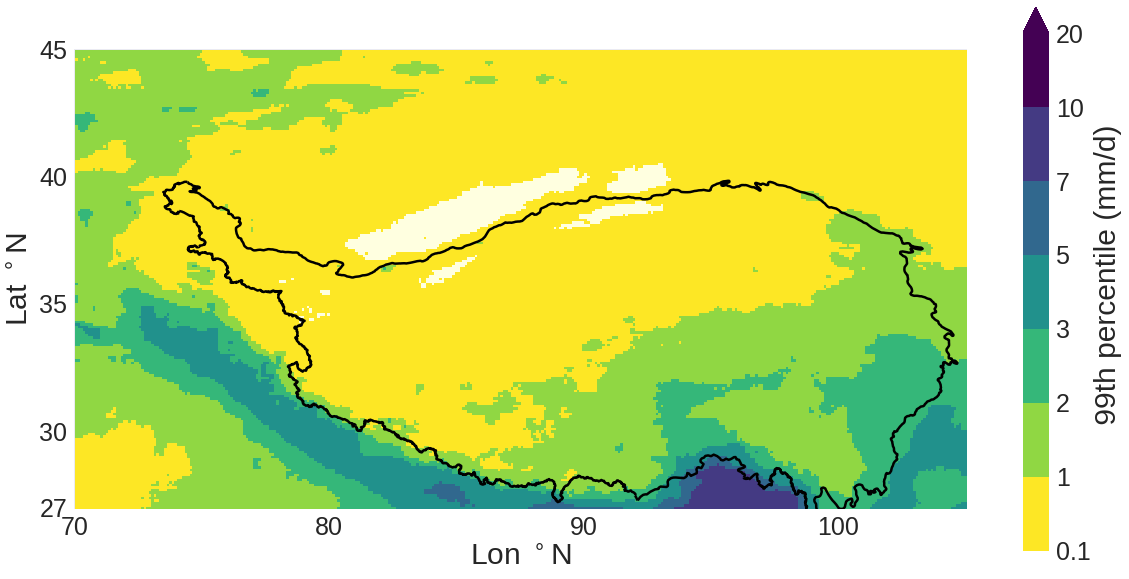

In [204]:
file = '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/GPM_IMERG_daily_2014_2018.nc4'
prec, lons, lats, date, time= read_in_netcdf(file, filename)
prec99=  prec[0,:]

plt.figure(figsize=(20, 10))

cmap = plt.cm.get_cmap('viridis_r')
bounds= np.array([0.1, 1 , 2, 3, 5, 7, 10, 20])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors= 256)

m = Basemap(projection='cyl', llcrnrlat=26.95,urcrnrlat=44.95, llcrnrlon=70.05, urcrnrlon=105.05,  resolution = 'c')
#m = Basemap(width=4000000,height=3000000,resolution='l', projection='aea',lat_1=27.,lat_2=45,lon_0=90, lat_0= (45+27)/2)

lon, lat =np.meshgrid(lons[:,0], lats[0,:])
xi,yi = m(lon,lat)
cs = m.pcolormesh(xi,yi, prec99.T, cmap=cmap, norm = norm, vmin= 0.1, vmax = 20 )
cmap.set_under(color='lightyellow')

xlabels=[70, 80, 90, 100]
ylabels= [ 27, 30, 35, 40, 45]

plt.xticks([70, 80,90, 100], xlabels, fontsize=25)
plt.yticks([27,30, 35, 40, 45],ylabels, fontsize=25)
plt.xlabel('Lon $^\circ$N',  fontsize=30)
plt.ylabel('Lat $^\circ$N',  fontsize=30)

# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=2.5)


cbar = plt.colorbar(extend= 'max')
cbar.set_label(' 99th percentile (mm/d)', fontsize= 30)
cbar.set_ticks(bounds)
labels = ['0.1', '1', '2', '3', '5', '7', '10', '20']
cbar.set_ticklabels(labels)

plt.rcParams.update({'font.size': 25})


plt.savefig('/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/tracks/plots/gpm_daily_avg_grid_2014_2018.png')

In [106]:
np.nansum(prec99)*(31+30+31+31+30)

19388757.65625

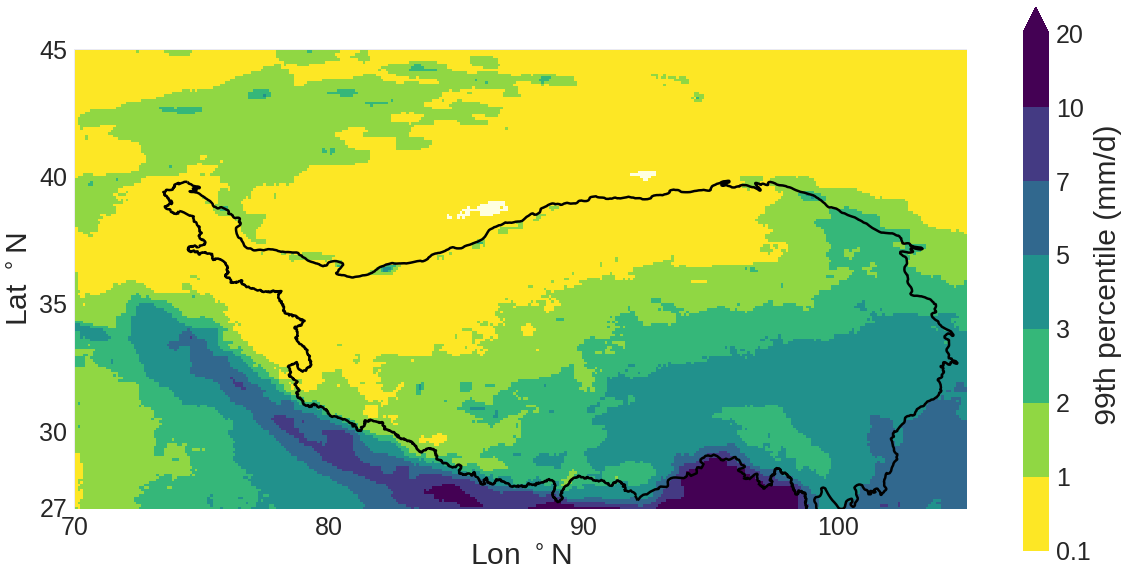

In [104]:
file = '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/GPM_IMERG_summer_2014_2018.nc4'
prec, lons, lats, date, time= read_in_netcdf(file, filename)
prec99=  prec[0,:]

plt.figure(figsize=(20, 10))

cmap = plt.cm.get_cmap('viridis_r')
bounds= np.array([0.1, 1 , 2, 3, 5, 7, 10, 20])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors= 256)

m = Basemap(projection='cyl', llcrnrlat=26.95,urcrnrlat=44.95, llcrnrlon=70.05, urcrnrlon=105.05,  resolution = 'c')
#m = Basemap(width=4000000,height=3000000,resolution='l', projection='aea',lat_1=27.,lat_2=45,lon_0=90, lat_0= (45+27)/2)

lon, lat =np.meshgrid(lons[:,0], lats[0,:])
xi,yi = m(lon,lat)
cs = m.pcolormesh(xi,yi, prec99.T, cmap=cmap, norm = norm, vmin= 0.1, vmax = 20 )
cmap.set_under(color='lightyellow')

xlabels=[70, 80, 90, 100]
ylabels= [ 27, 30, 35, 40, 45]

plt.xticks([70, 80,90, 100], xlabels, fontsize=25)
plt.yticks([27,30, 35, 40, 45],ylabels, fontsize=25)
plt.xlabel('Lon $^\circ$N',  fontsize=30)
plt.ylabel('Lat $^\circ$N',  fontsize=30)

# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=2.5)


cbar = plt.colorbar(extend= 'max')
cbar.set_label(' 99th percentile (mm/d)', fontsize= 30)
cbar.set_ticks(bounds)
labels = ['0.1', '1', '2', '3', '5', '7', '10', '20']
cbar.set_ticklabels(labels)

plt.rcParams.update({'font.size': 25})


plt.savefig('/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/tracks/plots/gpm_summer_2014_2018.png')